# Data Loading and Processing
The goal of this deep learning section is to predict the location(being latitude and longitude) of the hurricane in the next timestamp given the information we use to predict radius of wind speed.

In [1]:
import pandas as pd
import numpy as np
import os
# from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

import pickle 

In [2]:
print(os.getcwd(),os.listdir())

file_path1 = '../data/ibtracs.since1980.list.v04r01.csv.zip'  
zip_file = ZipFile(file_path1)

df1 = pd.read_csv(zip_file.open('ibtracs.since1980.list.v04r01.csv'))

df1 = df1.iloc[:, 1:]

df = df1.copy()

df

/Users/beatrixwen/Orkanskader/orkanskader/src ['county_valuator.py', 'Rmax_Prediction.ipynb', 'old', 'pdf_parse.py', 'run.sh', 'Rmax_Prediction_FL.ipynb', 'Deep_Learning_Hurricane_Location.ipynb', 'shape_proj.py', 'county_bounds.py']


/var/folders/y9/hy0mnzl536ng5c4qz99ppmf00000gn/T/ipykernel_98219/2958032689.py:6: DtypeWarning: Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(zip_file.open('ibtracs.since1980.list.v04r01.csv'))


,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,Year,,,,,,,degrees_north,degrees_east,kts,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,,...,,,,,,,,,6,350
2,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,,...,,,,,,,,,6,350
3,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,,...,,,,,,,,,5,360
4,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,,...,,,,,,,,,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297547,2024,81,WP,MM,YINXING,2024-11-04 12:00:00,NR,14.3,130.1,,...,,,,,,,,,15,310
297548,2024,81,WP,MM,YINXING,2024-11-04 15:00:00,NR,14.7,129.6,,...,,,,,,,,,13,305
297549,2024,81,WP,MM,YINXING,2024-11-04 18:00:00,NR,15.1,129.0,,...,,,,,,,,,15,305
297550,2024,81,WP,MM,YINXING,2024-11-04 21:00:00,NR,15.6,128.3,,...,,,,,,,,,18,305


Set radius to zero when it is reasonable to do so. Aside from that, remove the lines with missing data.

In [3]:
#keep what we will use for learning(and the output R)

df2 = df[['NAME','ISO_TIME','LAT','LON', 'USA_WIND','USA_R34_NE', 'USA_R50_NE', 'USA_R64_NE','USA_RMW']].copy()
df2 = df2.iloc[1:]#remove the first row

df2.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

#make the items numerical values for computation
df2[['USA_R34_NE']] = df2[['USA_R34_NE']].apply(pd.to_numeric, errors='coerce')
df2[['USA_RMW', 'USA_R64_NE','USA_R50_NE']] = df2[['USA_RMW', 'USA_R64_NE','USA_R50_NE']].apply(pd.to_numeric, errors='coerce')
df2[['USA_WIND']] = df2[['USA_WIND']].apply(pd.to_numeric, errors='coerce')
df2[['LAT']] = df2[['LAT']].apply(pd.to_numeric, errors='coerce')

#remove missing data, if the max wind speed is less than x, set the radius of area with this wind speed to be 0
df2 = df2.dropna(subset=['USA_WIND'])
df2.loc[df2['USA_WIND']<64,'USA_R64_NE']=0
df2.loc[df2['USA_WIND']<50,'USA_R50_NE']=0
df2.loc[df2['USA_WIND']<34,'USA_R34_NE']=0

numeric_columns = ['LAT', 'USA_R34_NE', 'USA_RMW', 'USA_WIND']
df2.dropna(subset=numeric_columns, inplace=True)
df2.dropna(inplace=True)
df2

,NAME,ISO_TIME,LAT,LON,USA_WIND,USA_R34_NE,USA_R50_NE,USA_R64_NE,USA_RMW
151265,ADOLPH,2001-05-27 00:00:00,13.5,-100.2,40.0,120.0,0.0,0.0,40.0
151266,ADOLPH,2001-05-27 03:00:00,13.4,-100.1,45.0,120.0,0.0,0.0,40.0
151307,ADOLPH,2001-06-01 06:00:00,16.2,-112.0,45.0,50.0,0.0,0.0,20.0
151308,ADOLPH,2001-06-01 09:00:00,16.2,-112.1,40.0,40.0,0.0,0.0,35.0
151309,ADOLPH,2001-06-01 12:00:00,16.3,-112.3,35.0,30.0,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...
297533,RAFAEL,2024-11-04 18:00:00,15.1,-76.4,40.0,70.0,0.0,0.0,70.0
297534,RAFAEL,2024-11-04 21:00:00,15.4,-76.6,40.0,80.0,0.0,0.0,55.0
297535,RAFAEL,2024-11-05 00:00:00,15.8,-76.9,40.0,90.0,0.0,0.0,40.0
297536,YINXING,2024-11-03 06:00:00,9.7,138.2,29.0,0.0,0.0,0.0,65.0


In [4]:
#split data by hurriance, making each hurricane its own dataset
datasets = [group for _, group in df2.groupby('NAME')]


In [5]:
#split datasets into train (80%), validation (10%), and test (10%)
train_datasets, temp_datasets = train_test_split(datasets, test_size=0.2, random_state=42)
val_datasets, test_datasets = train_test_split(temp_datasets, test_size=0.5, random_state=42)

print(f"Number of training datasets: {len(train_datasets)}")
print(f"Number of validation datasets: {len(val_datasets)}")
print(f"Number of testing datasets: {len(test_datasets)}")


Number of training datasets: 785
Number of validation datasets: 98
Number of testing datasets: 99


#Training
Train the LSTM models(one for latitude and one for longitude) using each hurricane in the training set separately,then validate and test using the remaining hurricanes.

In [6]:
class LSTMModel(nn.Module):#use LSTM model because it remembers the entire path instead of only using the previous information
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    lstm_out = lstm_out[:, -1, :]
    pred = self.fc(lstm_out)
    return pred


In [7]:
#preparing the data, essentially transform all data to numerical values, then preparing them in the list returned.
def prepare_data_for_training(dataset, sequence_length=5):
  features = ['LAT', 'LON', 'USA_WIND', 'USA_R34_NE', 'USA_R50_NE', 'USA_R64_NE', 'USA_RMW']
  target_lat = 'LAT'
  target_lon = 'LON'

  #sort data by time as we care about the hurricane movement by time
  dataset = dataset.sort_values(by='ISO_TIME')

  #convert all feature columns to numeric
  dataset[features] = dataset[features].apply(pd.to_numeric, errors='coerce')
  dataset[target_lat] = pd.to_numeric(dataset[target_lat], errors='coerce')
  dataset[target_lon] = pd.to_numeric(dataset[target_lon], errors='coerce')

  #drop columns without target lattidude and longitude, being the last row(as we cannot find its true next position)
  dataset.dropna(subset=features + [target_lat, target_lon], inplace=True)

  X, y_lat, y_lon = [], [], []
  data_values = dataset[features].values
  lat_values = dataset[target_lat].values
  lon_values = dataset[target_lon].values

  for i in range(sequence_length, len(dataset)):
    X.append(data_values[:i].astype(np.float32))
    y_lat.append(lat_values[i])
    y_lon.append(lon_values[i])

  return X, y_lat, y_lon


In [8]:
#parameters used for training
input_dim = len(['LAT', 'LON', 'USA_WIND', 'USA_R34_NE', 'USA_R50_NE', 'USA_R64_NE', 'USA_RMW'])
hidden_dim = 64
output_dim = 1
learning_rate = 0.001
num_epochs = 10
sequence_length = 5



In [9]:
# #initalize lattitude and longitude model
# model_lat = LSTMModel(input_dim, hidden_dim, output_dim)#LAT
# model_lon = LSTMModel(input_dim, hidden_dim, output_dim)#LON

# model_lat.load_state_dict(torch.load("../checkpoint/model_lat.pth", weights_only=True))
# model_lon.load_state_dict(torch.load("../checkpoint/model_lon.pth", weights_only=True))

In [10]:
#initalize lattitude and longitude model
model_lat = LSTMModel(input_dim, hidden_dim, output_dim)#LAT
model_lon = LSTMModel(input_dim, hidden_dim, output_dim)#LON

try: #try to load the model if it exists
    print("Loading trained model from file...")
    model_lat.load_state_dict(torch.load("../checkpoint/model_lat.pth", weights_only=True))
    model_lon.load_state_dict(torch.load("../checkpoint/model_lon.pth", weights_only=True))
except: 
    print("Model not found, training from scratch.")
    #loss function
    criterion = nn.MSELoss()
    optimizer_lat = torch.optim.Adam(model_lat.parameters(), lr=learning_rate)
    optimizer_lon = torch.optim.Adam(model_lon.parameters(), lr=learning_rate)

    #train separately for each hurricane
    for dataset_idx, dataset in enumerate(train_datasets):
        print(f"Training on dataset {dataset_idx + 1}/{len(train_datasets)}")

        #get data for current dataset
        X_train, y_lat_train, y_lon_train = prepare_data_for_training(dataset, sequence_length=5)

        #skip if there isnt enough data
        if len(X_train) == 0:
            print(f"Skipping dataset {dataset_idx + 1} due to insufficient data.")
            continue

        #convert to tensors
        X_train_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_train]
        y_lat_train_tensor = torch.tensor(y_lat_train, dtype=torch.float32).unsqueeze(1)
        y_lon_train_tensor = torch.tensor(y_lon_train, dtype=torch.float32).unsqueeze(1)

        #train in this dataset
        for epoch in range(num_epochs):
            total_loss_lat = 0.0
            total_loss_lon = 0.0
            model_lat.train()
            model_lon.train()

            for i in range(len(X_train_tensor)):
                #train lattitude
                optimizer_lat.zero_grad()
                input_seq = X_train_tensor[i].unsqueeze(0)
                lat_pred = model_lat(input_seq)
                loss_lat = criterion(lat_pred, y_lat_train_tensor[i].unsqueeze(0))
                loss_lat.backward()
                optimizer_lat.step()
                total_loss_lat += loss_lat.item()

                #train longitude
                optimizer_lon.zero_grad()
                lon_pred = model_lon(input_seq)
                loss_lon = criterion(lon_pred, y_lon_train_tensor[i].unsqueeze(0))
                loss_lon.backward()
                optimizer_lon.step()
                total_loss_lon += loss_lon.item()

            print(f"Epoch {epoch + 1}/{num_epochs}, Latitude Loss: {total_loss_lat / len(X_train_tensor):.4f}, Longitude Loss: {total_loss_lon / len(X_train_tensor):.4f}")
    # Save the latitude model
    torch.save(model_lat.state_dict(), "../checkpoint/model_lat.pth") # /cis/home/ywen15/Documents/Tornados/DL_of_ML_Final_Stuff.ipynb

    # Save the longitude model
    torch.save(model_lon.state_dict(), "../checkpoint/model_lon.pth")

    print("Models saved to local device.")

Loading trained model from file...


Validating on dataset 1/98
Validating on dataset 2/98
Validating on dataset 3/98
Validating on dataset 4/98
Validating on dataset 5/98
Validating on dataset 6/98
Validating on dataset 7/98
Validating on dataset 8/98
Validating on dataset 9/98
Validating on dataset 10/98
Validating on dataset 11/98
Validating on dataset 12/98
Validating on dataset 13/98
Validating on dataset 14/98
Validating on dataset 15/98
Validating on dataset 16/98
Validating on dataset 17/98
Validating on dataset 18/98
Validating on dataset 19/98
Validating on dataset 20/98
Validating on dataset 21/98
Validating on dataset 22/98
Validating on dataset 23/98
Validating on dataset 24/98
Validating on dataset 25/98
Validating on dataset 26/98
Validating on dataset 27/98
Validating on dataset 28/98
Validating on dataset 29/98
Validating on dataset 30/98
Validating on dataset 31/98
Validating on dataset 32/98
Validating on dataset 33/98
Validating on dataset 34/98
Validating on dataset 35/98
Validating on dataset 36/98
V

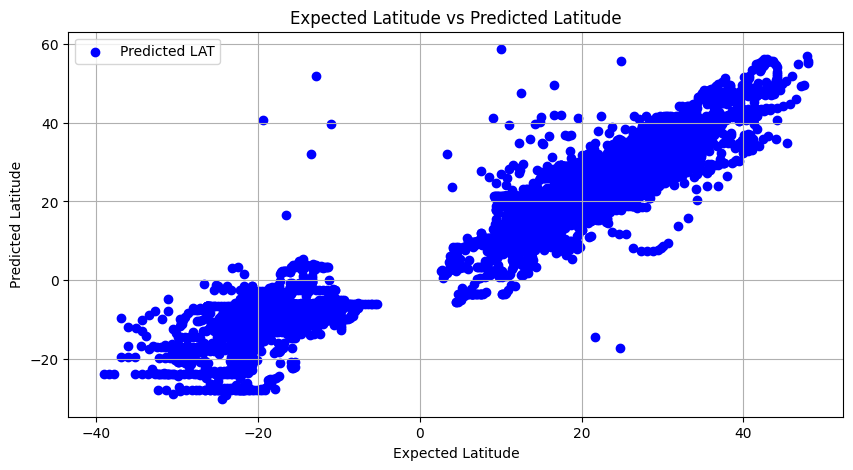

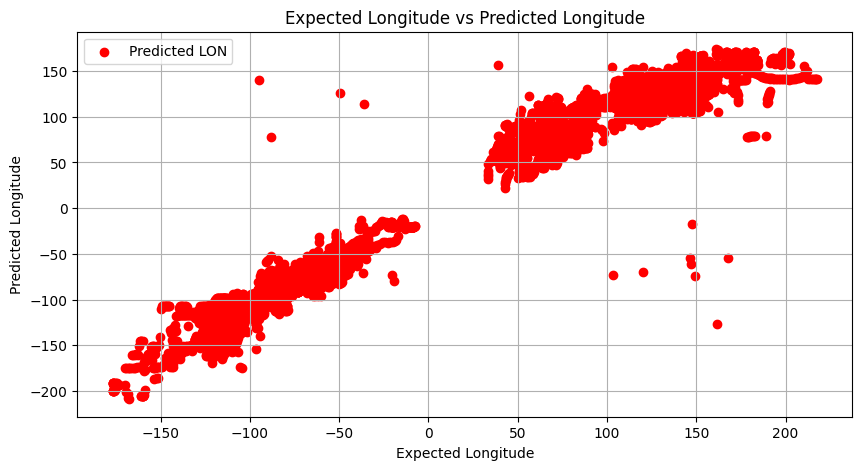

In [11]:
#validation and print out validation result

expected_lon_list = []
expected_lat_list = []
predicted_lat_list = []
predicted_lon_list = []

for dataset_idx, dataset in enumerate(val_datasets):
    print(f"Validating on dataset {dataset_idx + 1}/{len(val_datasets)}")

    #prepare data for the current dataset
    X_val, y_lat_val, y_lon_val = prepare_data_for_training(dataset, sequence_length=5)

    #convert to tensors
    X_val_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_val]
    y_lat_val_tensor = torch.tensor(y_lat_val, dtype=torch.float32).unsqueeze(1)
    y_lon_val_tensor = torch.tensor(y_lon_val, dtype=torch.float32).unsqueeze(1)

    #ensure models are in evaluation mode
    model_lat.eval()
    model_lon.eval()

    #compute predictions
    with torch.no_grad():
        for i in range(len(X_val_tensor)):
            input_seq = X_val_tensor[i].unsqueeze(0)

            #predict
            lat_pred = model_lat(input_seq)
            predicted_lat = lat_pred.item()
            lon_pred = model_lon(input_seq)
            predicted_lon = lon_pred.item()

            #store expected and predicted values
            expected_lon_list.append(y_lon_val_tensor[i].item())
            expected_lat_list.append(y_lat_val_tensor[i].item())
            predicted_lat_list.append(predicted_lat)
            predicted_lon_list.append(predicted_lon)

#plot expected latitutde/longitude vs actual latitude/longitude
plt.figure(figsize=(10, 5))
plt.scatter(expected_lat_list, predicted_lat_list, c='blue', label='Predicted LAT')
plt.title("Expected Latitude vs Predicted Latitude")
plt.xlabel("Expected Latitude")
plt.ylabel("Predicted Latitude")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(expected_lon_list, predicted_lon_list, c='red', label='Predicted LON')
plt.title("Expected Longitude vs Predicted Longitude")
plt.xlabel("Expected Longitude")
plt.ylabel("Predicted Longitude")
plt.legend()
plt.grid()
plt.show()


Testing on dataset 1/99
Testing on dataset 2/99
Testing on dataset 3/99
Testing on dataset 4/99
Testing on dataset 5/99
Testing on dataset 6/99
Testing on dataset 7/99
Testing on dataset 8/99
Testing on dataset 9/99
Testing on dataset 10/99
Testing on dataset 11/99
Testing on dataset 12/99
Testing on dataset 13/99
Testing on dataset 14/99
Testing on dataset 15/99
Testing on dataset 16/99
Testing on dataset 17/99
Testing on dataset 18/99
Testing on dataset 19/99
Testing on dataset 20/99
Testing on dataset 21/99
Testing on dataset 22/99
Testing on dataset 23/99
Testing on dataset 24/99
Testing on dataset 25/99
Testing on dataset 26/99
Testing on dataset 27/99
Testing on dataset 28/99
Testing on dataset 29/99
Testing on dataset 30/99
Testing on dataset 31/99
Testing on dataset 32/99
Testing on dataset 33/99
Testing on dataset 34/99
Testing on dataset 35/99
Testing on dataset 36/99
Testing on dataset 37/99
Testing on dataset 38/99
Testing on dataset 39/99
Testing on dataset 40/99
Testing o

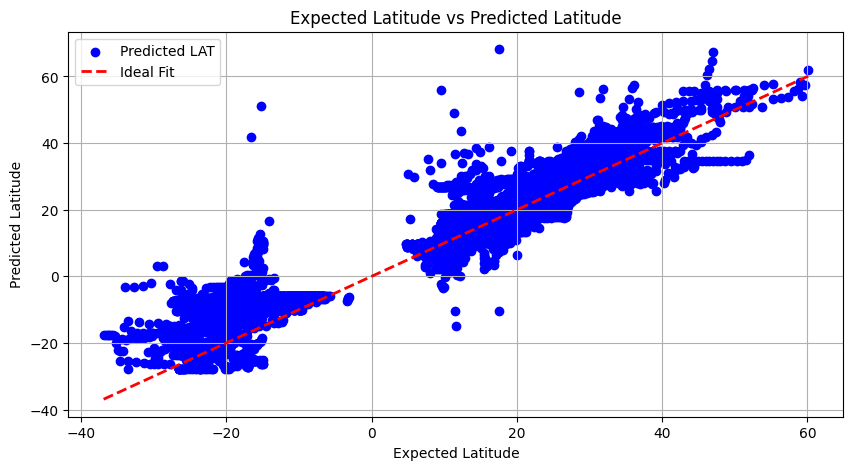

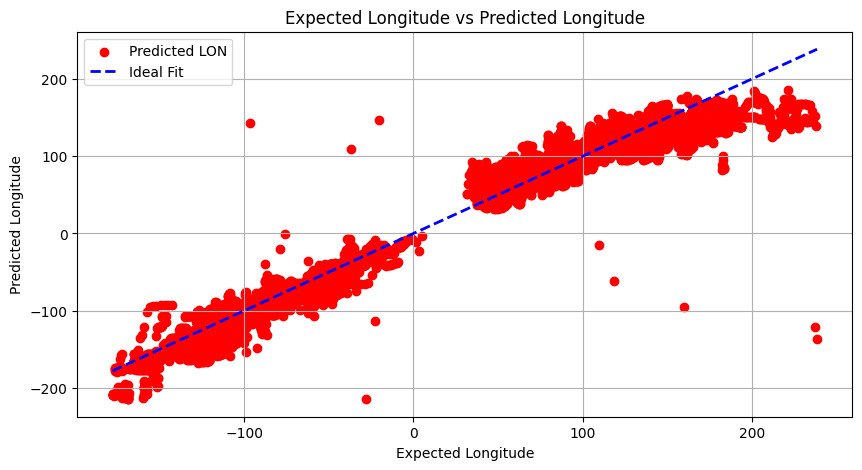

In [12]:
#testing and print out testing result

expected_lon_list = []
expected_lat_list = []
predicted_lat_list = []
predicted_lon_list = []

for dataset_idx, dataset in enumerate(test_datasets):
    print(f"Testing on dataset {dataset_idx + 1}/{len(test_datasets)}")

    #prepare data for the current dataset
    X_test, y_lat_test, y_lon_test = prepare_data_for_training(dataset, sequence_length=5)

    #convert to tensors
    X_test_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_test]
    y_lat_test_tensor = torch.tensor(y_lat_test, dtype=torch.float32).unsqueeze(1)
    y_lon_test_tensor = torch.tensor(y_lon_test, dtype=torch.float32).unsqueeze(1)

    #ensure models are in evaluation mode
    model_lat.eval()
    model_lon.eval()

    #compute predictions
    with torch.no_grad():
        for i in range(len(X_test_tensor)):
            input_seq = X_test_tensor[i].unsqueeze(0)

            #predict
            lat_pred = model_lat(input_seq)
            predicted_lat = lat_pred.item()
            lon_pred = model_lon(input_seq)
            predicted_lon = lon_pred.item()

            #store expected and predicted values
            expected_lon_list.append(y_lon_test_tensor[i].item())
            expected_lat_list.append(y_lat_test_tensor[i].item())
            predicted_lat_list.append(predicted_lat)
            predicted_lon_list.append(predicted_lon)

#plot expected latitutde/longitude vs actual latitude/longitude
plt.figure(figsize=(10, 5))
plt.scatter(expected_lat_list, predicted_lat_list, c='blue', label='Predicted LAT')
plt.plot([min(expected_lat_list), max(expected_lat_list)], [min(expected_lat_list), max(expected_lat_list)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.title("Expected Latitude vs Predicted Latitude")
plt.xlabel("Expected Latitude")
plt.ylabel("Predicted Latitude")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(expected_lon_list, predicted_lon_list, c='red', label='Predicted LON')
plt.plot([min(expected_lon_list), max(expected_lon_list)], [min(expected_lon_list), max(expected_lon_list)], color='blue', linestyle='--', linewidth=2, label='Ideal Fit')
plt.title("Expected Longitude vs Predicted Longitude")
plt.xlabel("Expected Longitude")
plt.ylabel("Predicted Longitude")
plt.legend()
plt.grid()
plt.show()
